In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.interpolate import interp1d
# from plot_funcs import *
from matplotlib import patches

In [2]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [3]:
# relative difference
def rel_dif(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    delta_y = (interp_y2 - interp_y1) / interp_y1
    return common_x, delta_y

In [4]:
def rMAE_av_cosmo(pred_parent, sim_parent, z):
    Ps_pred, nz_ind = load_pred(pred_parent, z)
    k_sim, Ps_sim = load_sim(sim_parent, z, nz_ind)
    k, rAEs = rel_MAEs(k_sim, Ps_sim, k_sim, Ps_pred)
    rMAE_av = np.mean(rAEs, axis=0)

    rAE_av_k = np.mean(rAEs, axis=1)
    print('z=', z, rAE_av_k)
    # print('z=', z, rAEs)
    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

def load_pred(pred_parent, z):
    Ps_pred = []
    nz_ind = []  # for matching sim spectra
    for i in range(21):
        file_path = os.path.join(pred_parent, "matter_pow_z%s_l%d.txt" % (z, i))
        if os.path.exists(file_path):
            # print(f"The file {file_path} exists.")
            data = np.loadtxt(file_path,)
            data = data.transpose()
            P_pred = data[-1]
            Ps_pred.append(P_pred)
            nz_ind.append(i)
        else:
            print(f"The file {file_path} does not exist.")
            continue
    Ps_pred = np.array(Ps_pred)
    return Ps_pred, nz_ind

def load_sim(sim_parent, z, nz_ind):
    file_path = os.path.join(sim_parent, 'matter_power_564_Box1000_Part750_21_Box1000_Part3000_z%s/train_output_fidelity_1.txt' % z)
    k_path = os.path.join(sim_parent, 'matter_power_564_Box1000_Part750_21_Box1000_Part3000_z%s/kf.txt' % z)
    lg_Ps = np.loadtxt(file_path)
    lg_Ps = lg_Ps[nz_ind]
    Ps_sim = 10**lg_Ps
    lg_k = np.loadtxt(k_path, usecols=(0))
    k_sim = 10**lg_k
    return k_sim, Ps_sim


def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

In [5]:
# P_pred = np.loadtxt('matter_pow_z0_l0.txt', usecols=(2))

z= 0 [0.03117071 0.01623292 0.05474284 0.01709771 0.02569561 0.04231549
 0.01270584 0.0426023  0.04290591 0.02799306 0.03229481 0.02549202
 0.00715614 0.03472265 0.02136551 0.01412573 0.04119876 0.04557253
 0.08900568 0.03335544 0.030347  ]
z= 0.2 [0.03567728 0.01500852 0.0593883  0.01763213 0.030844   0.03331949
 0.01892796 0.04006641 0.03799087 0.03341285 0.03534672 0.03486732
 0.00923432 0.04116836 0.02380927 0.00857947 0.05398376 0.01997358
 0.10553312 0.03961185 0.02235564]
z= 0.5 [0.03717239 0.01569227 0.05160393 0.02008724 0.03142981 0.04361442
 0.01492548 0.03532343 0.02644789 0.02880799 0.04550813 0.01846805
 0.01012108 0.04241712 0.02146642 0.01283546 0.05741049 0.01711073
 0.0828953  0.03671701 0.01141769]
z= 1 [0.03185065 0.01100803 0.04343751 0.02023946 0.03696096 0.03284524
 0.01880515 0.03864447 0.03733963 0.02926754 0.0477741  0.01699978
 0.01053357 0.03079813 0.01987639 0.00947078 0.05041476 0.01798083
 0.08194905 0.0241931  0.01783765]
z= 2 [0.03832011 0.00916884 0.04

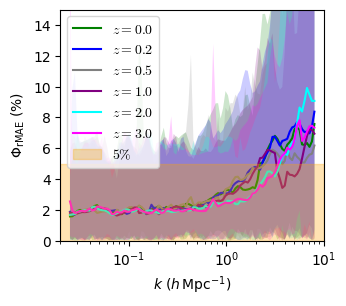

In [6]:
# relative
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_parent = "../data" 
pred_parent = './loo_upper/'

fig, ax = plt.subplots(figsize=(3.4,3.))
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

color_list = ['green', 'blue', 'grey', 'purple', 'cyan', 'magenta']

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []

for i, scale in enumerate(a):
    if i==6:
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_parent, sim_parent, zs_str[i])
    rMAE_zs.append(rMAE.mean())
    # k_HF, Pk_HF = load_rebin(os.path.join(sim_HF, "output/powerspectrum-%.4f.txt" % scale))
    # k_li, Pk_li = np.loadtxt(os.path.join(sim_HF, "camb_linear/ics_matterpow_%s.dat" % zs_str[i]), usecols=(0,1), unpack=True)

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    # ax.plot(k_li, Pk_li, '--', color=c)
    # individual
    # for rAE in rAEs:
    #     ax.plot(k, rAE/1e-2, color=c, alpha=0.4)

    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z:', rMAE_zs_mean)
    # plt.loglog(k_HF, Pk_HF, color=c, label=r"$z=%.1f$" % zs[i])
    

    # if labels is not None:

# ax.set_ylim(.07,.5e5)
# ax.legend(loc='best')
# ax.set_yscale('log')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 15)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 5, color='orange', alpha=.3, zorder=2, label=r'$5\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# square1 = patches.Rectangle((xlim1, -0.01), xlim2-xlim1, 0.02, color='blue', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)

# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')
# ax.set_yticks([-0.2,-.1,0,.1,.2])

# plt.xlim([0.005, 100])
# plt.ylim([.01,4e5])
# plt.ylim([-.3, .3])
plt.show()
# plt.savefig('matter_pow_nonl_linear_ratio.pdf', bbox_inches='tight')

z= 0 [0.01916782 0.00899934 0.03162877 0.01237809 0.01456887 0.01556143
 0.01281106 0.03073286 0.0225039  0.02190459 0.01774778 0.02071864
 0.00764282 0.02617472 0.01605794 0.00642617 0.02619489 0.03737535
 0.05333187 0.01719399 0.02344433]
z= 0.2 [0.02389024 0.00876476 0.03673415 0.01184006 0.01859953 0.00864889
 0.01591608 0.03077518 0.01919672 0.02664722 0.02605828 0.02845799
 0.00698824 0.03316866 0.01098972 0.00860532 0.03106771 0.01709523
 0.07066156 0.02291988 0.01806516]
z= 0.5 [0.02419862 0.00897211 0.03082514 0.01381203 0.01496416 0.01130797
 0.01400783 0.02975821 0.01421669 0.02075619 0.03078262 0.01300506
 0.00608942 0.0336071  0.00709077 0.00964291 0.03532766 0.01599205
 0.05164546 0.01934447 0.00969068]
z= 1 [0.02096699 0.00731545 0.02175957 0.01139129 0.01609499 0.01035942
 0.0147247  0.03110028 0.02062153 0.0215376  0.03080829 0.01228599
 0.0071884  0.02507817 0.00929746 0.005712   0.03475217 0.01310614
 0.04452843 0.01432571 0.01501103]
z= 2 [0.02611413 0.00647228 0.02

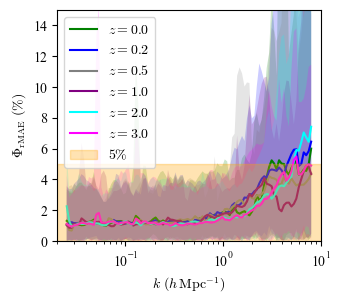

In [7]:
# relative  lower
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_parent = "../data" 
pred_parent = './'

fig, ax = plt.subplots(figsize=(3.4,3.))
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

color_list = ['green', 'blue', 'grey', 'purple', 'cyan', 'magenta']

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []

for i, scale in enumerate(a):
    if i==6:
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_parent, sim_parent, zs_str[i])
    rMAE_zs.append(rMAE.mean())
    # k_HF, Pk_HF = load_rebin(os.path.join(sim_HF, "output/powerspectrum-%.4f.txt" % scale))
    # k_li, Pk_li = np.loadtxt(os.path.join(sim_HF, "camb_linear/ics_matterpow_%s.dat" % zs_str[i]), usecols=(0,1), unpack=True)

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    # ax.plot(k_li, Pk_li, '--', color=c)
    # individual
    # for rAE in rAEs:
    #     ax.plot(k, rAE/1e-2, color=c, alpha=0.4)

    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, color=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z:', rMAE_zs_mean)
    # plt.loglog(k_HF, Pk_HF, color=c, label=r"$z=%.1f$" % zs[i])
    

    # if labels is not None:

# ax.set_ylim(.07,.5e5)
# ax.legend(loc='best')
# ax.set_yscale('log')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 15)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 5, color='orange', alpha=.3, zorder=2, label=r'$5\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# square1 = patches.Rectangle((xlim1, -0.01), xlim2-xlim1, 0.02, color='blue', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)

# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')
# ax.set_yticks([-0.2,-.1,0,.1,.2])

# plt.xlim([0.005, 100])
# plt.ylim([.01,4e5])
# plt.ylim([-.3, .3])
plt.show()
# plt.savefig('matter_pow_nonl_linear_ratio.pdf', bbox_inches='tight')